In [1]:
%matplotlib inline

# Putting it all in practice

Use the provided Tasmanian catchments and go through a typical workflow of calibration, simulation, benchmarking and visualisation

In [2]:
# 1. Import required libraries
import pandas as pd
from os.path import join
import h5py

from awrams.models.awral.model import AWRALModel

from awrams.utils.nodegraph import nodes, graph

from awrams.utils import gis
from awrams.utils import datetools as dt
from awrams.utils import extents
from awrams.utils.settings_manager import get_settings
from awrams.utils.gis import ShapefileDB, CATCHMENT_SHAPEFILE

from awrams.calibration.optimizers import sce
from awrams.calibration.objectives import test_objectives as tobj
from awrams.calibration.support import *
from awrams.calibration import cluster
from awrams.calibration.launch_calibration import run_from_pickle

from matplotlib import pyplot as plt

In [3]:
from awrams.models.settings import TRAINING_DATA_PATH
TRAINING_DATA_PATH

'/data/cwd_awra_data/AWRACMS/Training/test_data/'

## Configure model

In [4]:
# Instantiate the AWRA-L model

awral = AWRALModel()

In [5]:
#import list
from awrams.benchmarking.utils import read_id_csv
data_path = TRAINING_DATA_PATH
id_list = read_id_csv('./Tasmanian_5catchments.csv')

In [6]:
id_list

['306119', '308145', '312061', '318150', '318852']

In [7]:
calvalshapefile = ShapefileDB(CATCHMENT_SHAPEFILE)

# Define the extenst of the calibration

def_extent = extents.get_default_extent() 

## Create a dict with multiple extents
cal_dict = {}

cal_catchments = id_list

for catchment in cal_catchments:
    cal_dict[catchment] = calvalshapefile.get_extent_by_field('StationID', catchment.zfill(6), parent_extent=def_extent)
    
cal_dict

{'306119': origin: -42.8,146.25, shape: (15, 14), cell_size: 0.05,
 '308145': origin: -42.05,145.75, shape: (6, 9), cell_size: 0.05,
 '312061': origin: -41.4,145.55, shape: (3, 5), cell_size: 0.05,
 '318150': origin: -41.35,147.55, shape: (12, 15), cell_size: 0.05,
 '318852': origin: -41.35,146.45, shape: (10, 10), cell_size: 0.05}

/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/visualisation/vis.py:82: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  to_plot.data[c_ext.indices][c_ext.mask==False] = 2.0


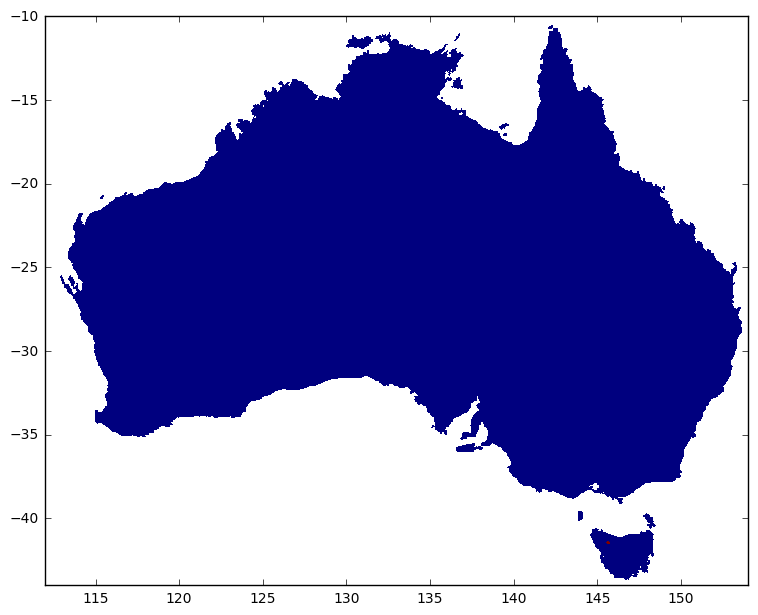

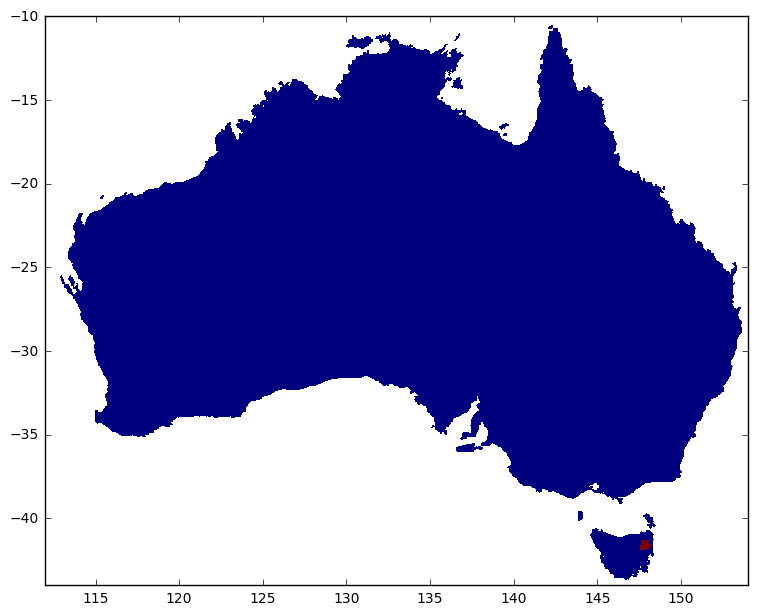

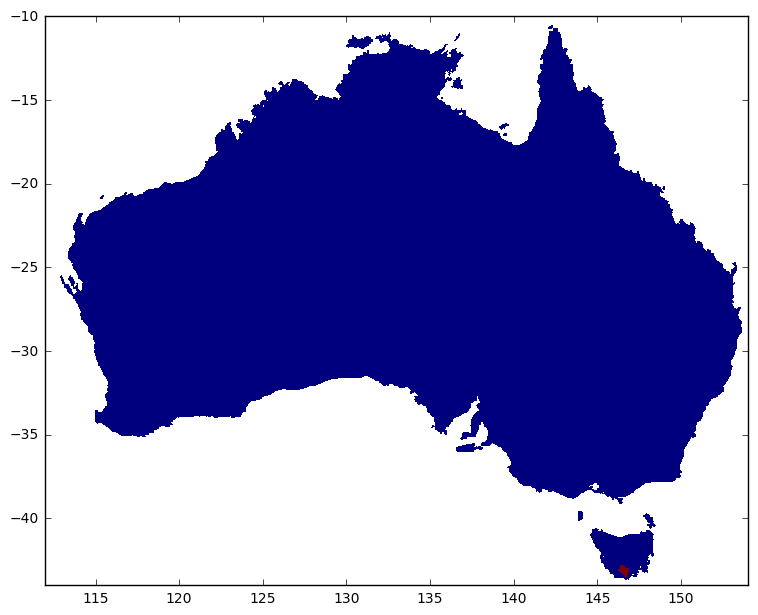

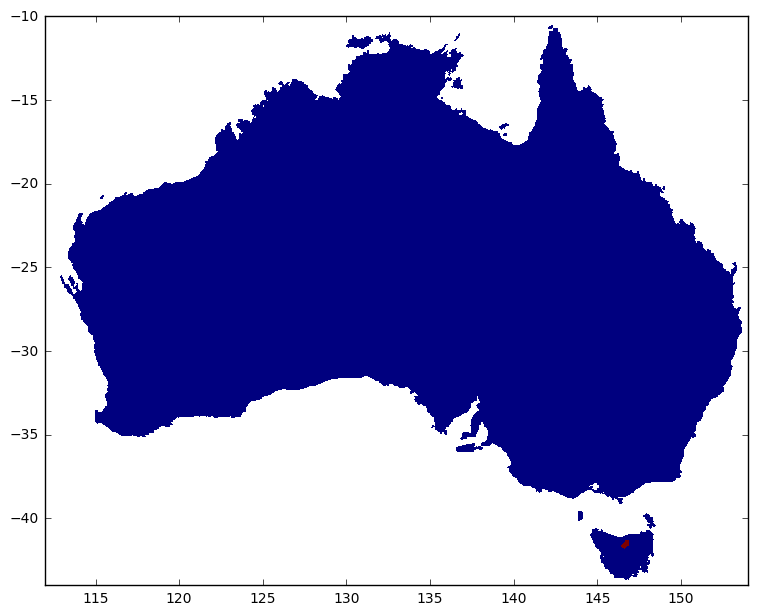

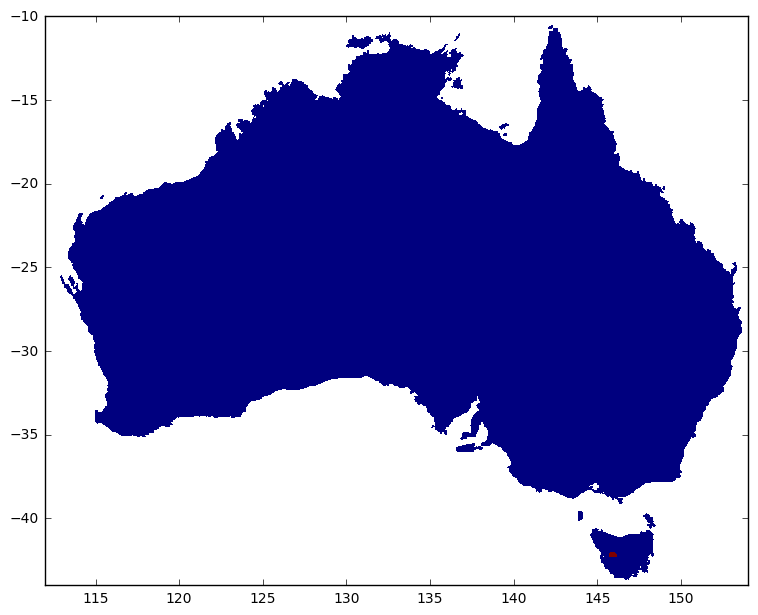

In [8]:
import awrams.visualisation.vis as vis
import awrams.visualisation.results as res

import awrams.utils.extents as extents

vis.show_extent(cal_dict['312061'],def_extent)
vis.show_extent(cal_dict['318150'],def_extent)
vis.show_extent(cal_dict['306119'],def_extent)
vis.show_extent(cal_dict['318852'],def_extent)
vis.show_extent(cal_dict['308145'],def_extent)

In [10]:
#Specify observation location
observations = dict(qtot = data_path +'calibration/Catchment_Qobs.csv')

In [11]:
#Check model inputs
def change_path_to_forcing(imap):
    from awrams.utils.nodegraph import nodes
    from os.path import join
    from os import getcwd

    data_path = TRAINING_DATA_PATH + 'climate/BOM_climate/'
    FORCING = {
        'tmin': ('temp_min*.nc','temp_min_day',data_path + 'temp_min_day/'),
        'tmax': ('temp_max*.nc','temp_max_day',data_path + 'temp_max_day/'),
        'precip': ('rain_day*.nc','rain_day',data_path + 'rain_day/'),
        'solar': ('solar*.nc','solar_exposure_day',data_path + 'solar_exposure_day/') #,
    }
    for k,v in FORCING.items():
        imap[k+'_f'] = nodes.forcing_from_ncfiles(v[2],v[0],v[1])

In [12]:
input_map = awral.get_default_mapping()

In [13]:
change_path_to_forcing(input_map)

In [14]:
## there are gaps to solar data in 2009, infill the dataset.
def insert_solar_climatology(imap):
    from awrams.utils.nodegraph import nodes
    # from awrams.models.settings import CLIMATOLOGIES
    CLIMATOLOGIES = {'solar': (TRAINING_DATA_PATH + '/simulation/climatology/Rad_1990_2009.nc', 'solar_exposure_day')}
   
    imap = imap.copy()
    
    imap['solar_f_orig'] = imap['solar_f'] #'Move' the forcing node to a new name
    imap['solar_climatology_f'] = nodes.monthly_climatology(*CLIMATOLOGIES['solar']) # Loads monthly climatology from default file

    # Replace 'solar_f' with infilled data
    # This ensures that any other nodes in the graph who use solar_f as input will automatically receive the infilled data
    # nodes.gap_filler takes the first argument as 'gappy' data, and in infills with data from the second argument
    imap['solar_f']  = nodes.gap_filler('solar_f_orig','solar_climatology_f')
    
    return imap

In [15]:
input_map = insert_solar_climatology(input_map)

In [16]:
## Better to use appropriate start states

In [17]:
# Using the same data as above, but this time load the states into memory, and store in a python dictionary
# Use this when you want to compute custom states, for example
INITIAL_STATES_PATH = TRAINING_DATA_PATH + '/simulation/initial_states/' # This data is for  30 Nov 2010

def initial_states_from_dict(imap,period,extent):
    from awrams.utils.io.data_mapping import SplitFileManager
    from awrams.utils.nodegraph import nodes
    
    mapping = imap.copy()

    data_path = INITIAL_STATES_PATH

    node_names = {'mleaf_dr': 'init_mleaf_hrudr',
                  'mleaf_sr': 'init_mleaf_hrusr',
                  's0_dr': 'init_s0_hrudr',
                  's0_sr': 'init_s0_hrusr',
                  #'ss_dr': 'init_ss_hrudr',
                  #'ss_sr': 'init_ss_hrusr',
                  #'sd_dr': 'init_sd_hrudr',
                  #'sd_sr': 'init_sd_hrusr',
                  'sg_bal': 'init_sg',
                  'sr_bal': 'init_sr'
                 }

    data_map = {}
    #period = [period[0] - 1] # Use states from the previous day
    period = dt.dates('30 nov 2010') # Use states from predefined date instead
    
    for k in node_names:
        sfm = SplitFileManager.open_existing(data_path,k+'*nc',k)
        data_map[node_names[k]] = sfm.get_data(period,extent)[0]  # At this point you could manipulate the initial states data
        
    # nodes.init_states_from_dict is a convenience function to update a mapping in-place
    nodes.init_states_from_dict(mapping,data_map,extent)
    
    return mapping


In [18]:
input_map = initial_states_from_dict(input_map,run_period,def_extent)

## Calibrate

In [9]:
#Specify running and calibration period
run_period = dt.dates('2009 - 2011')
eval_period = dt.dates('2010 - 2011')

In [19]:
#Select optimiser
evolver_spec = EvolverSpec(sce.CCEvolver,
                           evolver_run_args=dict(n_offspring=1,n_evolutions=5,elitism=2.0))

optimizer_spec = OptimizerSpec(sce.ShuffledOptimizer,
                               evolver_spec=evolver_spec,
                               n_complexes=3,
                               max_nsni=500,
                               min_complexes=1,
                               max_eval=2000) #n_complex 14

#optimizer_spec = OptimizerSpec(SobolOptimizer,threshold = 0.005,max_eval =10000)

In [20]:
#Import objective function

In [21]:
local_objfspec = ObjectiveFunctionSpec(tobj.TestLocalSingle)  # this function to load up the ObjFunc comes from awrams.calibration.support
global_objfspec = tobj.TestGlobalSingle

In [22]:
objective_spec = ObjectiveSpec(global_objfspec,local_objfspec,observations,eval_period)

In [23]:
# Build spec dict
# Get the input mapping and model
node_mapping = input_map
model = awral#callable_to_funcspec(awral)

In [24]:
# Create the calibration specification dictionary

'''
User specifiable calibration description
'''
cal_spec = {}
cal_spec['optimizer_spec'] = optimizer_spec
cal_spec['objective_spec'] = objective_spec
cal_spec['extent_map'] = cal_dict
cal_spec['run_period'] = run_period
cal_spec['eval_period'] = eval_period
cal_spec['model'] = model
cal_spec['node_mapping'] = node_mapping
#cal_spec['logfile'] = '/short/er4/dss548/calibration_res.h5'
cal_spec['logfile'] = './tas_cal.h5'

In [25]:
# Save a file containing all the calibration specifications
cluster.build_pickle_from_spec(cal_spec,1,'tas_cal.pkl')

{'catch_node_map': {'306119': [0],
  '308145': [0],
  '312061': [0],
  '318150': [0],
  '318852': [0]},
 'eval_period': DatetimeIndex(['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04',
                '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
                '2010-01-09', '2010-01-10',
                ...
                '2011-12-22', '2011-12-23', '2011-12-24', '2011-12-25',
                '2011-12-26', '2011-12-27', '2011-12-28', '2011-12-29',
                '2011-12-30', '2011-12-31'],
               dtype='datetime64[ns]', length=730, freq='D'),
 'extent_map': {'306119': origin: -42.8,146.25, shape: (15, 14), cell_size: 0.05,
  '308145': origin: -42.05,145.75, shape: (6, 9), cell_size: 0.05,
  '312061': origin: -41.4,145.55, shape: (3, 5), cell_size: 0.05,
  '318150': origin: -41.35,147.55, shape: (12, 15), cell_size: 0.05,
  '318852': origin: -41.35,146.45, shape: (10, 10), cell_size: 0.05},
 'logfile': './tas_cal.h5',
 'model': <awrams.models.awral.model.AWR

In [26]:
#import mpi4py
#from awrams.calibration.launch_calibration import run_from_pickle

cal = run_from_pickle('./tas_cal.pkl')

s:  733
n

 evaluating initial population
{}
.......
 running
{'n_shuffle': 1, 'n_eval': 145, 'best_params': Score: 0.735257163033, Params: [ 0.03163113  0.0203536   0.23665281  0.7576133   0.76796928  5.73836374
  6.68779702  0.79952418  2.24365982  0.4526973   0.49742677  5.46632603
  0.04494026  1.14568589  1.5054996   0.67986616  0.7657175   0.95172847
  0.73782786  1.6672068   4.88299472], Meta: None}

 running
{'n_shuffle': 3, 'n_eval': 168, 'best_params': Score: 0.735257163033, Params: [ 0.03163113  0.0203536   0.23665281  0.7576133   0.76796928  5.73836374
  6.68779702  0.79952418  2.24365982  0.4526973   0.49742677  5.46632603
  0.04494026  1.14568589  1.5054996   0.67986616  0.7657175   0.95172847
  0.73782786  1.6672068   4.88299472], Meta: None}

 running
{'n_shuffle': 5, 'n_eval': 184, 'best_params': Score: 0.735257163033, Params: [ 0.03163113  0.0203536   0.23665281  0.7576133   0.76796928  5.73836374
  6.68779702  0.79952418  2.24365982  0.4526973   0.49742677  5.4663260

In [27]:
#Extract best parameter set

In [28]:
cr = CalibrationResults('./tas_cal.h5')

In [29]:
# Obtain the best (minimum score) parameter set
best_params = cr.get_best_paramset()
new_params = pd.DataFrame(best_params, columns=['Value'])
new_params['MemberName'] = new_params.index


In [30]:
# Run the model with new parameter set. Change the parameter set in teh input map

def change_model_parameters(imap, param_df):
    """
    the intent of this function is to replace the values in imap (your current configuration) 
    by values in a new parameter dataframe (param_df)
    """
    
    import pandas as pd
    
    variable_names = param_df['MemberName']
    variable_value = param_df['Value']
    #variable_fixed = param_df['Fixed']
    #variable_max = param_df['Max']
    #variable_min = param_df['Min']
    # Convert to lower case for the input_mapping
      
    #for k,v,f,vmax,vmin in zip(variable_names,variable_value, variable_fixed, variable_max, variable_min):
    for k,v in zip(variable_names, variable_value):
        imap[k.lower()].args['value'] = v
        #imap[k.lower()].args['fixed'] = f
        #imap[k.lower()].args['max'] = vmax
        #imap[k.lower()].args['min'] = vmin
        
change_model_parameters(input_map, new_params)

## Simulate

In [31]:
#Load up a  server simulator to run the model to write outputs out

from awrams.simulation import server

In [32]:
# Confirm output settings

omap = awral.get_output_mapping()

def build_output_mapping(output_map, outpath):
    from awrams.utils.nodegraph import nodes
   
    FILE_OUTPUT_VARS = ['s0','ss','sd','qtot','etot']
    
    for f in FILE_OUTPUT_VARS:
            output_map[f+'_ncsave'] = nodes.write_to_annual_ncfile(outpath,f)

    return output_map

In [33]:
outpath = './_results_tas_cal/'
omap = build_output_mapping(omap, outpath)

In [34]:
sim = server.SimulationServer(awral)


In [35]:
from awrams.utils import datetools as dt
period = dt.dates('jan 2009 - dec 2011')


In [36]:
## The functionality to model multiple extents at a time is coming. In the meantime, either:
## model 1 catchment at a time or model the entire bounding box..ie. Tasmania coords[-39.5:-44,143.5:149]

sim.run(input_map,omap,period,def_extent.icoords[-39.5:-44,143.5:149])

2017-11-22 08:06:28,197 INFO Getting I/O dataspecs...
2017-11-22 08:06:29,947 INFO Initialising output files...
2017-11-22 08:06:31,222 INFO Building buffers...
2017-11-22 08:06:32,428 INFO Running simulation...
2017-11-22 08:06:35,906 INFO completed 10.00%
2017-11-22 08:06:36,181 INFO completed 20.00%
2017-11-22 08:06:36,645 INFO completed 30.00%
2017-11-22 08:06:36,868 INFO completed 40.00%
2017-11-22 08:06:37,144 INFO completed 50.00%
2017-11-22 08:06:37,968 INFO completed 60.00%
2017-11-22 08:06:39,126 INFO completed 70.00%
2017-11-22 08:06:39,620 INFO completed 80.00%
2017-11-22 08:06:40,539 INFO completed 90.00%
2017-11-22 08:06:41,056 INFO completed 100.00%
2017-11-22 08:06:41,059 INFO Completed period 2009 - 1 of 3
2017-11-22 08:06:42,042 INFO completed 10.00%
2017-11-22 08:06:42,334 INFO completed 20.00%
2017-11-22 08:06:42,889 INFO completed 30.00%
2017-11-22 08:06:43,188 INFO completed 40.00%
2017-11-22 08:06:43,464 INFO completed 50.00%
2017-11-22 08:06:43,701 INFO complete

In [37]:
# Extract outputs into csv's for each catchment
import os
import pandas as pd
from awrams.utils import extents
from awrams.utils.io.data_mapping import SplitFileManager
from awrams.utils.processing.extract import extract_from_filemanager
from awrams.utils.gis import ShapefileDB, CATCHMENT_SHAPEFILE

catchments = ShapefileDB(CATCHMENT_SHAPEFILE)

var_name = 'qtot'
model_data_path = os.getcwd() + '/_results_tas_cal/'
period = dt.dates('jan 2009 - dec 2011')

pattern = model_data_path + '/%s*' % var_name
sfm = SplitFileManager.open_existing(model_data_path,pattern,var_name)
georef = sfm.get_extent()
    
df = extract_from_filemanager(sfm, cal_dict, period)
df

,312061,306119,308145,318852,318150
2009-01-01,6.76648,9.84089,9.92044,2.34127,1.249
2009-01-02,3.06707,6.62167,5.9611,1.38009,1.01789
2009-01-03,1.41689,4.89724,4.00523,0.918437,0.869264
2009-01-04,0.685037,3.91967,2.85711,0.694948,0.78205
2009-01-05,0.358957,3.37505,2.17881,0.585194,0.733324
2009-01-06,0.215542,3.07795,1.80673,0.528705,0.705663
2009-01-07,0.146862,2.89874,1.57424,0.497313,0.6889
2009-01-08,0.118038,2.85163,1.51427,0.478075,0.677663
2009-01-09,0.100867,2.76084,1.43387,0.464829,0.669157
2009-01-10,0.0889742,2.6632,1.34291,0.454175,0.66201


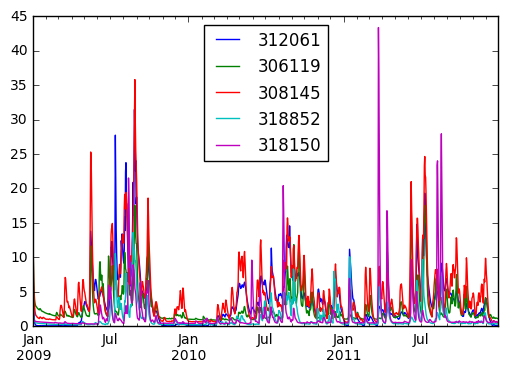

In [38]:
df.plot()

In [39]:
df.to_csv('./tas_cal_qtot.csv')

### Benchmark

In [40]:
from awrams.benchmarking.benchmark import Benchmark

obs_csv = data_path +'calibration/Catchment_Qobs.csv'

In [41]:
q = Benchmark("QObs", "runoff")

# Specify benchmarking period
q.period = dt.dates("2010", "30/12/2011")

# Add observations and catchment subset [the id list needs to be present in the column names of the observation file]
q.load(obs_csv, id_list=id_list)

/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/benchmarking/comparison.py:34: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  self.obs.monthly = self.obs.data.resample(rule='m', how=self.aggr_how)
/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/benchmarking/comparison.py:35: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  self.obs.annual = self.obs.data.resample(rule='A', how=self.aggr_how)


In [42]:
## Add model outputs
## Default AWRAL calibration
csv_data = data_path+'/benchmarking/runoff/AWRAMSI_v5QES_AWRAL_qtot_avg.csv'
q.add_model("AWRAMSI_v5_0_AWRAL", data_csv=csv_data)

## Regional Tasmanian calibration
csv_data = './tas_cal_qtot.csv'
q.add_model("Tas_Cal", data_csv=csv_data)


/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/benchmarking/utils.py:147: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  _df = cur_data[valid_idx].resample(rule='m', how=np.mean).dropna()
/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/benchmarking/utils.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  monthly_data = pd.DataFrame(_df,index=_df.index|valid_idx).fillna(method='bfill').resample(rule='m', how=np.sum)[col_name]
/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/benchmarking/utils.py:177: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  out_dct[col] = ts.resample(annual_rule, how)
/data/cwd_awra_data/AWRACMS/MINICONDA3/envs/awra-cms/lib/python3.4/site-packages/awrams/benchmarking/stats.py:299: RuntimeWarn

In [43]:
## View stats
q.benchmark.stat_percentiles('nse', freq='d')

,0%,5%,25%,50%,75%,95%,100%
AWRAMSI_v5_0_AWRAL,0.363417,0.392293,0.507796,0.560813,0.590282,0.738368,0.775390
Tas_Cal,0.468226,0.501815,0.636170,0.655263,0.664092,0.773288,0.800587


In [44]:
q.benchmark.stat(statistic='nse')

,AWRAMSI_v5_0_AWRAL,Tas_Cal
306119,0.292616,0.475784
312061,0.905937,0.893396
308145,0.860336,0.892673
318852,0.653975,0.872589
318150,0.960136,0.926500
all,0.820971,0.860078


In [45]:
q.benchmark.stat() 

,AWRAMSI_v5_0_AWRAL,Tas_Cal,QObs
306119,68.153558,73.352639,112.658133
312061,98.506280,102.359365,91.163745
308145,126.034806,129.206709,142.732967
318852,26.660397,35.714447,38.286565
318150,34.848821,47.460587,37.117900
all,70.840773,77.618750,84.391862


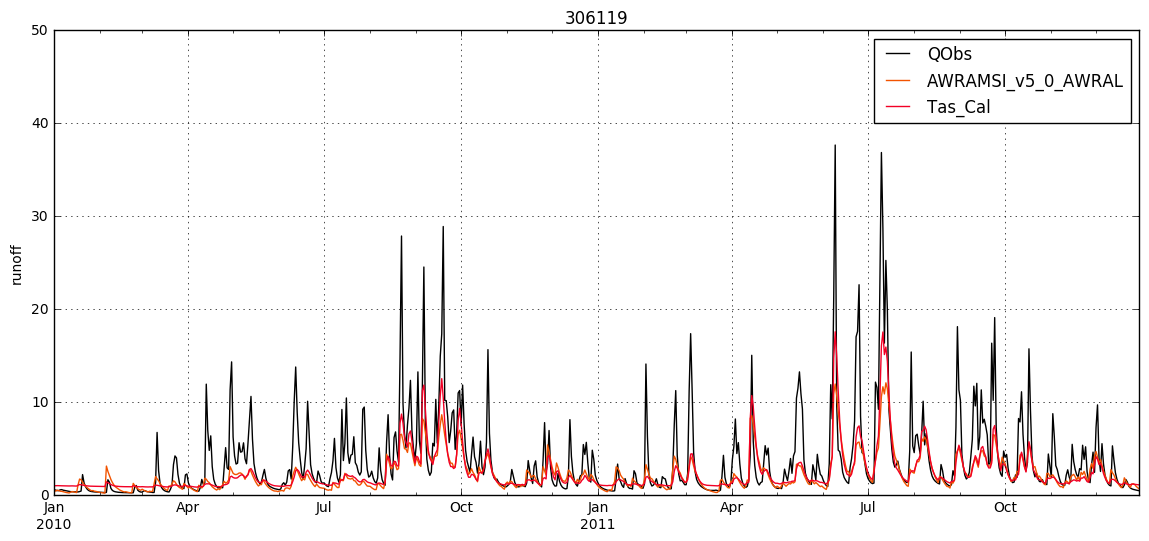

In [47]:
p = q.benchmark.plot_timeseries('306119',ylim=[0,50], freq = 'd')

## Visualise